## Load packages

Code from Chin-Chieh Wu (Chang Gung University)

In [ ]:
dep_packages <- c("prophet",
          "dplyr",
          "plyr",
          "hydroGOF",
          "plotly",
          "forecast")
new.packages <- dep_packages[!(dep_packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
lapply(dep_packages, require, character.only = TRUE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘wk’, ‘classInt’, ‘s2’, ‘units’, ‘intervals’, ‘abind’, ‘lwgeom’, ‘checkmate’, ‘matrixStats’, ‘proxy’, ‘sf’, ‘sftime’, ‘spacetime’, ‘stars’, ‘FNN’, ‘reshape’, ‘TTR’, ‘inline’, ‘gridExtra’, ‘loo’, ‘e1071’, ‘gstat’, ‘automap’, ‘sp’, ‘maptools’, ‘later’, ‘quadprog’, ‘quantmod’, ‘Rcpp’, ‘dygraphs’, ‘extraDistr’, ‘RcppParallel’, ‘rstan’, ‘rstantools’, ‘StanHeaders’, ‘xts’, ‘BH’, ‘RcppEigen’, ‘zoo’, ‘hydroTSM’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’


Loading required package: prophet

Loading required package: Rcpp

Loading required package: rlang

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required p

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [ ]:
library(prophet)
library(dplyr)
library(plyr)
library(hydroGOF)
library(plotly)
library(forecast)

## Data pre-processing

### Import Data

In [ ]:
url='https://raw.githubusercontent.com/wujinja-cgu/Time-Series-Analysis/main/time%20series%20data.csv'
mydata=read.csv(url)
mydata=as.data.frame(mydata)
head(mydata)
nrow(mydata)

,DATE,No
,<chr>,<int>
1,10/09/2007,325
2,10/10/2007,417
3,10/11/2007,556
4,10/12/2007,467
5,10/13/2007,430
6,10/14/2007,434


[1] 2996

### Re-scale the date format

In [ ]:
colnames(mydata)=c("ds","y")
mydata$ds=seq(as.Date('2007-10-09'),by='days',length=nrow(mydata))

##  Model derivation

### Split data into training and testing sets

In [ ]:
training=mydata[1:2641,]    # years 2007-2014 as the training set
testing=mydata[2642:2996,]  # year 2015 as the testing set

### Modeling

In [ ]:
modelfit=prophet(df=training,
         growth="linear",
         changepoints=NULL,
         n.changepoints=25,
         yearly.seasonality=TRUE,
         weekly.seasonality=TRUE,
         daily.seasonality=TRUE,
                 holidays=NULL,
                 seasonality.prior.scale=10,
                 changepoint.prior.scale=2.8,
                 holidays.prior.scale=10,
                 mcmc.samples=100,
                 interval.width=0.8,
                 uncertainty.samples=1000,
                 fit=TRUE)

future=make_future_dataframe(modelfit,periods=355)
future$cap=450
tail(future)


SAMPLING FOR MODEL 'prophet' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.008373 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 83.73 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: WARNING: There aren't enough warmup iterations to fit the
Chain 1:          three stages of adaptation as currently configured.
Chain 1:          Reducing each adaptation stage to 15%/75%/10% of
Chain 1:          the given number of warmup iterations:
Chain 1:            init_buffer = 7
Chain 1:            adapt_window = 38
Chain 1:            term_buffer = 5
Chain 1: 
Chain 1: Iteration:  1 / 100 [  1%]  (Warmup)
Chain 1: Iteration: 10 / 100 [ 10%]  (Warmup)
Chain 1: Iteration: 20 / 100 [ 20%]  (Warmup)
Chain 1: Iteration: 30 / 100 [ 30%]  (Warmup)
Chain 1: Iteration: 40 / 100 [ 40%]  (Warmup)
Chain 1: Iteration: 50 / 100 [ 50%]  (Warmup)
Chain 1: Iteration: 51 / 100 [ 51%]  (Sampling)
Chain 1: Iteration: 60 / 100 [ 

Warning message:
“There were 200 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.17, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


,ds,cap
,<dttm>,<dbl>
2991,2015-12-16,450
2992,2015-12-17,450
2993,2015-12-18,450
2994,2015-12-19,450
2995,2015-12-20,450
2996,2015-12-21,450


### Make prediction

In [ ]:
forecast=predict(modelfit,future)
pred_train=forecast[1:2641,c('ds','yhat','yhat_lower','yhat_upper')]
pred_train=as.data.frame(pred_train)
pred_test=forecast[2642:2996,c('ds','yhat','yhat_lower','yhat_upper')]
pred_test=as.data.frame(pred_test)
preddata_train=cbind(training[,"y"],pred_train[,'yhat'])
preddata_test=cbind(testing[,"y"],pred_test[,'yhat'])

### Calculate the error of prediction

#### error

In [ ]:
error_train=c(preddata_train[,1])-c(preddata_train[,2])
error_test=c(preddata_test[,1])-c(preddata_test[,2])
error_train
error_test

[1] -1.159288e+02 -4.690307e+01  4.010259e+01  8.116424e-01 -2.331323e+00
   [6]  9.166419e+00  1.456865e+01 -1.425465e+01  1.212031e+01  7.036816e+01
  [11] -2.279430e+01  5.307449e+01  2.246798e+01 -4.434568e+01 -6.048866e+01
  [16] -3.152613e+01 -4.769604e+00 -3.748615e+01 -3.321626e+01 -7.447422e+00
  [21]  9.108134e+00 -3.865229e+01 -3.527516e+01 -5.054728e+00  4.757262e+00
  [26] -2.366886e+00 -4.904769e+00 -1.056201e+01  5.956183e+01  2.691975e+01
  [31]  2.121341e+01  2.618341e+01  1.291147e+00 -9.954837e+00 -2.627655e+01
  [36] -2.679195e+01  2.793218e+01  7.757686e+01 -1.013801e+01 -1.477123e+01
  [41] -2.833262e+00 -6.063269e+00 -2.159398e+01 -1.300407e+01  2.337897e+01
  [46] -1.472993e+01 -1.389065e+01  2.138916e+01  8.377009e+00  2.095056e+01
  [51]  9.544977e+00  3.684958e+01  1.055987e+02  5.025384e+01 -7.670028e+00
  [56]  2.411791e+01  6.518491e+00  1.498922e+01  7.524024e+01  5.502447e+01
  [61]  3.681913e+01 -4.848373e+00  4.132138e+01  4.123373e+01  3.134636e+01
  [66]  6.636525e+01  2.103486e+01  5.681987e+01  3.523143e+01  5.354941e+01
  [71]  4.656931e+00 -2.401252e+01  2.622156e+01 -1.892226e+01  3.299521e+01
  [76] -1.453910e+01  4.173260e+01  2.567420e+01 -2.963614e-01  2.749011e+01
  [81]  1.774569e+01  1.490831e+01  1.646908e+01  2.469554e+01  9.466904e+00
  [86]  4.299360e+01  4.219851e+01 -6.217629e+01 -4.765912e+01 -4.372210e+01
  [91] -7.005884e+01 -5.375014e+01 -3.431736e+01  5.197340e+01 -9.098636e+00
  [96] -4.802769e+01 -8.425578e+01 -1.014514e+02 -9.267570e+01 -6.843706e+01
 [101] -6.099523e+01 -8.257191e+01 -7.866960e+01 -9.974598e+01 -1.154923e+02
 [106] -7.399939e+01 -1.018114e+02 -9.822937e+01 -1.195211e+02 -6.223892e+01
 [111] -3.389278e+01  7.477218e+01  2.026108e+02  1.870258e+02  4.666475e+01
 [116]  1.421174e+01 -7.492927e+01 -7.530701e+01 -9.469919e+01 -2.027686e+01
 [121] -2.565608e+01  2.079957e+01  2.770867e+00 -3.833400e+01  1.694804e+01
 [126] -1.114184e+01  1.125078e+01 -1.045884e+01  1.440209e+01  1.554826e+00
 [131] -5.488567e-01 -3.640027e+01 -2.871173e+01  1.041759e+01 -1.155189e+01
 [136]  3.909556e+01  5.512100e+01  2.101203e+01  5.230852e+01  5.032412e+01
 [141]  4.198003e+01  3.675113e+01  8.136174e+01  6.757558e+01  2.387729e+01
 [146]  3.179852e+01  1.163990e+01  3.730542e+01  1.624934e+01  3.617258e+01
 [151]  4.081362e+01 -3.636923e+01  1.612910e+01  6.458326e+01 -2.312744e+01
 [156] -5.714661e-01  8.931997e+00  3.110435e+01  3.239026e+01  4.728483e+01
 [161] -2.394351e+01  1.658212e+01  1.294472e+00  4.387892e+01 -6.393553e+01
 [166] -5.169405e+01 -3.188934e+01 -3.123926e+01 -3.185242e+01 -1.528132e+01
 [171]  7.921815e+01 -2.265601e+01 -2.437152e+00  2.391833e+00  8.120445e+00
 [176]  3.064473e+01  1.041387e+01  1.312627e+01  2.151990e+01  3.305415e+01
 [181]  2.123614e+01 -2.965693e+01  6.256717e+00 -3.158942e+01  3.148644e+01
 [186] -2.079466e+01 -1.198998e+01 -2.060816e+01 -9.386311e+00 -3.145492e+01
 [191] -1.439029e+01 -1.251750e+01  6.880855e+00 -3.375265e+01 -2.392323e+01
 [196] -4.360980e+00  8.814119e+00  2.039543e+00  3.700693e+01 -7.154704e+01
 [201] -7.115853e+01 -5.231003e+01 -1.270809e+01 -1.044900e+01 -6.072109e+00
 [206]  1.361792e-01 -1.906734e+01  2.379883e+01 -6.873312e+01  3.641466e+00
 [211]  5.833703e+00 -3.469244e+01  1.977576e+01 -3.010041e+00 -4.157761e+01
 [216] -3.640795e+01 -2.521319e+01  1.289787e+01 -2.663337e+01 -4.411876e+01
 [221] -1.483256e+01 -1.532908e+01  4.188420e+01 -1.193047e+01 -2.190602e+01
 [226] -2.962295e+01 -1.941220e+01  1.143619e+01 -4.864410e+01 -5.016844e+01
 [231]  2.312180e+01  1.209448e+01 -3.582574e+01  4.203952e+01 -3.586503e+00
 [236]  7.474666e+01  3.354346e+01  5.108484e+01  3.126278e+01 -6.472806e+00
 [241]  3.858214e+01  6.176207e+00 -1.421581e+01  1.793317e+01 -1.707565e+01
 [246]  3.166709e+01  5.262532e+01  1.075134e+02  2.108610e+01  7.820472e+00
 [251] -1.075846e+01  1.564446e+01  2.792870e+01  6.954482e+01  7.140695e+01
 [256]  3.703470e+01 -2.811594e+01  2.145781e+01  4.502815e+01  2.547168e+01

[1]  -20.19798982  -33.16721765  -20.26558052   33.02423935  -26.00180277
  [6]   11.56547642  -74.80463549  -28.38661343  -33.40843121  -34.37009382
 [11] -100.71780991  -71.12243796  -12.64585284  -42.79493863 -120.82621091
 [16]  -54.95617465  -23.68032446  -32.44761840  -30.93904789  -33.23394603
 [21]  -47.86373888  -84.11614816  -60.24495994  -18.78828043  -64.24212750
 [26] -117.33800235  -64.20810835  -43.43794874 -101.36934080  -65.30899071
 [31]  -45.84558079   -8.52224653  -52.11311672  -61.78760844  -12.16223272
 [36]   13.39703321   34.56664642   34.74870968   46.39860929  284.74840508
 [41]  348.64228371  345.48432787  168.93555789   85.70510168   17.23255176
 [46]   11.01464782   25.32763694   49.06164931   37.66737129   21.85199986
 [51]    6.36936316   73.70129155   27.38340273   -4.27332618  -26.34884257
 [56]  -14.36786282    4.39571783   15.70874032   -7.93989229  -47.01331717
 [61]   -7.20487676   41.39599920  -19.74952472   19.06653271   28.58960177
 [66]   16.28466811   -0.33701101   -2.99523880   68.19406120  -30.33368481
 [71]   42.10525330   31.23419790  -25.50126803   -8.60613008  -19.81293846
 [76]  -38.24665708  -73.47711079  -43.82207587   24.44384146   32.77159273
 [81]   48.66447558  -19.59933201   87.86784013   62.51011697    6.02436803
 [86]   81.15069966   20.35422593   -5.84872781  -31.16862345   20.29143717
 [91]  -26.01770567  -44.39526512  -14.10019629   -7.66949655  -15.59196164
 [96]  -10.58603418  -16.76540214  -16.69206681   15.32009519    5.99614668
[101]   16.78234527   26.17297776   19.43311658   -2.56637798   49.59864949
[106]   43.60261959   20.16150303   44.71546921   28.75602278   28.54896135
[111]   60.96946986  -29.55039264    3.67514317   24.37659729    4.01154056
[116]   -4.90871162   28.90333392  -10.65414870    3.87454247   22.19880290
[121]   40.07208195    4.97351289   30.43396762    0.75790060   22.85733139
[126]   24.19825487   24.49646859   72.50770359   43.70914139  -10.37452356
[131]  -15.44911087   21.38327587    0.57101865  -53.19072596    6.83065453
[136]   10.08737010   20.07797069   56.07003600   47.93513768   51.09633611
[141]   43.22516969    1.03299024  129.95369251   11.47096219   43.84137361
[146]   19.92965055   49.15634375   13.19487772   31.76281886   19.30441496
[151]   40.31753604   67.07635659   35.46610532    7.93015025   36.16638984
[156]   39.91782059   27.65435234   33.89902161   25.94996492   86.71449794
[161]   51.65558840   62.48771069   61.96696775   37.57256452   51.83279234
[166]  -27.95310738   15.11914809   15.50548857  -15.09040570  -59.92662505
[171]  -75.54110345  -21.42509761  -59.30072105  -87.28620240  -77.94860174
[176] -112.60702158  -95.54145582  -74.31022409  -71.42286503  -60.61715462
[181]   -2.02393422  -44.21949490  -21.52856417   12.76695512   -9.88945645
[186]  -29.00195141  -32.29956883  -33.90140201  -44.36941549  -74.01194451
[191]  -45.09300968  -56.15037977  -18.66923512   -9.36007382  -20.32451670
[196]  -38.10872686  -50.00745711  -58.27384121  -32.43784627  -19.98022638
[201]  -33.61060985  -25.43336996  -57.00099213  -32.61795172  -27.55022304
[206]   48.65665558  -13.49589123   -0.73700269   10.80837019   -7.43323510
[211]   49.21302052   28.46146310    4.74851621    0.55986467  -33.84649465
[216]   36.39499961   23.70518056  -22.24273346  -30.73177019  -33.31853363
[221]   -8.50610798   -0.02120176   -9.97921228   -1.93695053   -2.19606283
[226]  -24.01228675    7.08652273   18.62674011  -28.08895477  -29.14743149
[231]  -47.07861047  -50.15962654  -49.62476971  -22.98411998  -48.69771465
[236]  -32.45387747  -50.33535664  -19.87297964   20.65016524  -59.01109372
[241]    7.61760515  -30.94363151  -26.40678588  -12.88146800  -49.92788510
[246]  -24.86026953  -10.95590111   -8.77266498  -12.82201343   -2.84599387
[251]  -30.98202594   10.18482647  -12.68095932  -59.87387449   -3.96453863
[256]   20.52761124   17.85743327   28.88930861  -15.95526006   31.99927683
[261]   45.47362434  194.91599077   90.82881115   

#### MAPE

In [ ]:
MAPE_train=mean(abs(c(error_train)/c(preddata_train[,1])))
MAPE_test=mean(abs(c(error_test)/c(preddata_test[,1])))

#### MAE

In [ ]:
MAE_train=mean(abs(c(error_train)))
MAE_test=mean(abs(c(error_test)))

#### RMSE

In [ ]:
RMSE_train=rmse(preddata_train[,1],preddata_train[,2])
RMSE_test=rmse(preddata_test[,1],preddata_test[,2])

#### Print the results

In [ ]:
results=list("MAPE of training"=MAPE_train,
             "MAPE of testing"=MAPE_test,
             "MAE of training"=MAE_train,
             "MAE of testing"=MAE_test,
             "RMSE of training"=RMSE_train,
             "RMSE of testing"=RMSE_test)
print(results)

$`MAPE of training`
[1] 0.06218329

$`MAPE of testing`
[1] 0.07812216

$`MAE of training`
[1] 28.6459

$`MAE of testing`
[1] 37.12868

$`RMSE of training`
[1] 41.13781

$`RMSE of testing`
[1] 53.03761



## Time series plot

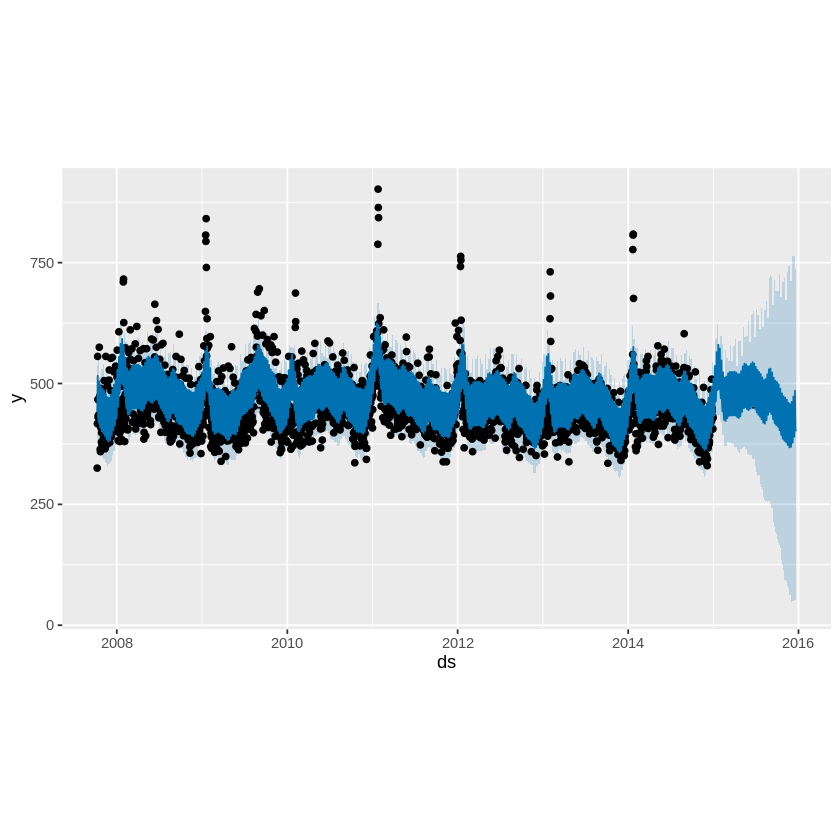

In [ ]:
plot(modelfit,forecast)